In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
from time import time

In [2]:
def calcula_distancias(nome):
    with open('Instancias/' + nome, 'r') as f:
        tsp = f.readlines()
    coord = list(map(lambda x: x.strip().split(' ')[1:],tsp[2:]))
    coord = list(map(lambda x: [int(x[i]) for i in range(len(x))],coord))
    dict_distancias = {(u,v): np.linalg.norm([coord[u][0]-coord[v][0],coord[u][1]-coord[v][1]]) for u in range(len(coord)) for v in range(len(coord))}
    n_variaveis = len(coord)
    return dict_distancias,n_variaveis

In [3]:
def calcula_custo(rota,dict_distancias, n_variaveis):
    custo = 0
    for u,v in zip(rota[:-1],rota[1:]):
        custo+= dict_distancias[u,v]
    return custo

In [4]:
def vizinho_mais_proximo(nome):
    dict_distancias,n_variaveis = calcula_distancias(nome)
    rota = [0]
    for _ in range(n_variaveis-1):
        u = rota[-1]
        dict_dist_u = {}
        for k in range(n_variaveis):
            if k not in rota:
                dict_dist_u[u,k] = dict_distancias[u,k]
        v = list(dict_dist_u.keys())[list(dict_dist_u.values()).index(min(dict_dist_u.values()))][1]
        rota.append(v)
    rota.append(0)
    custo = calcula_custo(rota,dict_distancias,n_variaveis)
    return rota, custo

In [5]:
def dois_opt(rota,nome):
    dict_distancias,n_variaveis = calcula_distancias(nome)
    custo = calcula_custo(rota,dict_distancias,n_variaveis)
    melhor_rota = rota.copy()
    for u in rota[1:-1]:
        for v in rota[1:-1]:
            rota2 = rota.copy()
            if u!=v:
                arg_u = rota2.index(u)
                arg_v = rota2.index(v)
                rota2.insert(arg_u, v)
                del rota2[arg_u+1]
                rota2.insert(arg_v, u)
                del rota2[arg_v+1]
                custo_novo = calcula_custo(rota2,dict_distancias,n_variaveis)
                if custo_novo<custo:
                    melhor_rota = rota2.copy()
    custo = calcula_custo(melhor_rota,dict_distancias,n_variaveis)
    return melhor_rota, custo

In [6]:
#Inserção do mais distante
def IMD(nome):
    dict_distancias,n_variaveis = calcula_distancias(nome)
    vertices = list(range(n_variaveis))
    rota = [np.random.choice(vertices)] #Vértice aleatorio para se iniciar
    rota.append(rota[0]) #inicio e fim no mesmo nó
    del vertices[vertices.index(rota[-1])] #deleta do conjunto de vértices os que já estavam na rota
    while len(rota)!=n_variaveis+1:
        distancia_min = np.inf
        for v in vertices:
            dist = sum([dict_distancias[(v,u)] for u in rota])
            if dist<distancia_min:
                distancia_min = dist
                no = v #Nó v é o mais distante, temos que adiciona-ló
        del vertices[vertices.index(no)] #deleta do conjunwtwo de vértices os que já estavam na rota
        dist_min = np.inf 
        for u,v in zip(rota[:-1],rota[1:]):
            dist = dict_distancias[u,no]+dict_distancias[no,v]-dict_distancias[u,v]
            if dist<dist_min:
                dist_min = dist
                indice = rota.index(v)
        rota.insert(indice,no)
        custo = calcula_custo(rota,dict_distancias, n_variaveis)
    return rota,custo

In [7]:
#Coloca os angulos no intervalo zero a dois pi
def zero_2pi(x):
    if x<0:
        return x + 2*np.pi
    else: 
        return x

In [8]:
def varredura(nome):
    with open('Instancias/' + nome, 'r') as f:
        tsp = f.readlines()
    coord = list(map(lambda x: x.strip().split(' ')[1:],tsp[2:]))
    coord = list(map(lambda x: [int(x[i]) for i in range(len(x))],coord))
    coord_x = np.array([x for x,_ in coord])
    coord_y = np.array([y for _,y in coord])
    angulos = np.zeros((2,coord_x.shape[0]))
    angulos[0] = np.arange(0,len(coord_x),1)
    angulos[1] = np.arctan2(coord_y,coord_x)
    angulos = angulos.T
    df = pd.DataFrame(angulos, columns = ['Loja','Angulo'])
    df['Angulo'] = df['Angulo'].map(zero_2pi)
    df = df.sort_values(by='Angulo', ascending=True)
    rota = df['Loja'].to_list()
    rota.append(rota[0])
    dict_distancias, n_variaveis = calcula_distancias(nome)
    custo = calcula_custo(rota,dict_distancias, n_variaveis)
    return rota, custo

In [9]:
def vizinho_2_opt(nome):
    rota, _ = vizinho_mais_proximo(nome)
    rota, custo = dois_opt(rota,nome)
    return rota,custo

In [10]:
def IMD_2_opt(nome):
    rota,_ = IMD(nome)
    rota, custo = dois_opt(rota,nome)
    return rota,custo

In [11]:
def varredura_2_opt(nome):
    rota,_ = varredura(nome)
    rota, custo = dois_opt(rota,nome)
    return rota,custo

In [12]:
def solver(tamanho, h, set_dois_opt=True):
    rotulos = [f'instancia{tamanho}x{tamanho}-{i}.txt' for i in range(1,11)]
    resultados = []
    if h == 'vizinho_mais_proximo':
        if set_dois_opt:
            for nome in rotulos:
                t1 = time()
                rota,custo = vizinho_2_opt(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
        else:
            for nome in rotulos:
                t1 = time()
                rota,custo = vizinho_mais_proximo(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
    elif h == 'IMD':
        if set_dois_opt:
            for nome in rotulos:
                t1 = time()
                rota,custo = IMD_2_opt(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
        else:
            for nome in rotulos:
                t1 = time()
                rota,custo = IMD(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
    elif h == 'varredura':
        if set_dois_opt:
            for nome in rotulos:
                t1 = time()
                rota,custo = varredura_2_opt(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
        else:
            for nome in rotulos:
                t1 = time()
                rota,custo = varredura(nome)
                t2 = time()
                resultados.append([rota,custo,t2-t1])
    try:
        if set_dois_opt:
            print(f'As 10 {tamanho}x{tamanho} instâncias foram resolvidas usando {h} com 2-opt ligado\n')
        else:
            print(f'As 10 {tamanho}x{tamanho} instâncias foram resolvidas usando {h} sem 2-opt ligado\n')
        for rota,custo,tempo in resultados:
            print(f'Custo: {custo}| Tempo: {tempo}| Rota: {rota}\n')
        print('\n')
    except:
        pass

In [13]:
ti = time()
for set_dois_opt in [True,False]:
    for h in ['vizinho_mais_proximo','IMD','varredura']:
        for tamanho in [10,25,50,100]:
            solver(tamanho,h,set_dois_opt)
tf = time()

As 10 10x10 instâncias foram resolvidas usando vizinho_mais_proximo com 2-opt ligado

Custo: 649.4492301988205| Tempo: 0.003999471664428711| Rota: [0, 1, 2, 7, 3, 9, 5, 4, 8, 6, 0]

Custo: 418.2990688564662| Tempo: 0.0030252933502197266| Rota: [0, 2, 4, 6, 8, 1, 9, 5, 7, 3, 0]

Custo: 569.9318334371266| Tempo: 0.0| Rota: [0, 4, 5, 2, 8, 3, 6, 9, 1, 7, 0]

Custo: 733.3989710400652| Tempo: 0.0| Rota: [0, 1, 6, 3, 7, 2, 9, 8, 4, 5, 0]

Custo: 512.7101983113791| Tempo: 0.0| Rota: [0, 9, 3, 2, 1, 8, 7, 6, 4, 5, 0]

Custo: 575.8188299484352| Tempo: 0.0| Rota: [0, 3, 8, 6, 2, 4, 1, 7, 5, 9, 0]

Custo: 441.7984757429919| Tempo: 0.014011383056640625| Rota: [0, 6, 4, 3, 9, 7, 5, 8, 2, 1, 0]

Custo: 735.5486932601891| Tempo: 0.0| Rota: [0, 9, 7, 6, 4, 2, 1, 5, 8, 3, 0]

Custo: 655.7786494698872| Tempo: 0.0| Rota: [0, 6, 9, 1, 3, 2, 8, 5, 7, 4, 0]

Custo: 575.2892697443629| Tempo: 0.0| Rota: [0, 5, 3, 1, 7, 9, 4, 6, 2, 8, 0]



As 10 25x25 instâncias foram resolvidas usando vizinho_mais_proximo co

In [14]:
tf-ti

22.78925609588623

In [18]:
Rota = [50.0, 82.0, 43.0, 33.0, 10.0, 0.0, 63.0, 12.0, 47.0, 83.0, 56.0, 91.0, 34.0, 52.0, 70.0, 17.0, 98.0, 92.0, 23.0, 57.0, 95.0, 84.0, 39.0, 67.0, 21.0, 78.0, 99.0, 85.0, 66.0, 46.0, 25.0, 51.0, 80.0, 35.0, 68.0, 97.0, 64.0, 31.0, 72.0, 74.0, 1.0, 36.0, 65.0, 18.0, 73.0, 62.0, 2.0, 54.0, 77.0, 11.0, 42.0, 44.0, 41.0, 19.0, 96.0, 89.0, 88.0, 87.0, 76.0, 40.0, 49.0, 61.0, 93.0, 20.0, 8.0, 9.0, 15.0, 27.0, 45.0, 60.0, 38.0, 28.0, 79.0, 69.0, 48.0, 90.0, 32.0, 5.0, 16.0, 7.0, 59.0, 14.0, 13.0, 30.0, 24.0, 53.0, 58.0, 71.0, 4.0, 86.0, 22.0, 75.0, 29.0, 37.0, 81.0, 3.0, 26.0, 94.0, 6.0, 55.0, 50.0]

In [36]:
Rota = [int(x) for x in Rota]

In [37]:
import networkx as nx

In [38]:
G = nx.Graph()

In [39]:
with open('Instancias/' + 'instancia100x100-10.txt', 'r') as f:
    tsp = f.readlines()
coord = list(map(lambda x: x.strip().split(' ')[1:],tsp[2:]))
coord = list(map(lambda x: [int(x[i]) for i in range(len(x))],coord))

In [40]:
for u in Rota:
    G.add_node(u, pos = (coord[u][0],coord[u][1]))

In [41]:
for u,v in zip(Rota[:-1],Rota[1:]):
    G.add_edge(u,v)

In [42]:
pos=nx.get_node_attributes(G,'pos')

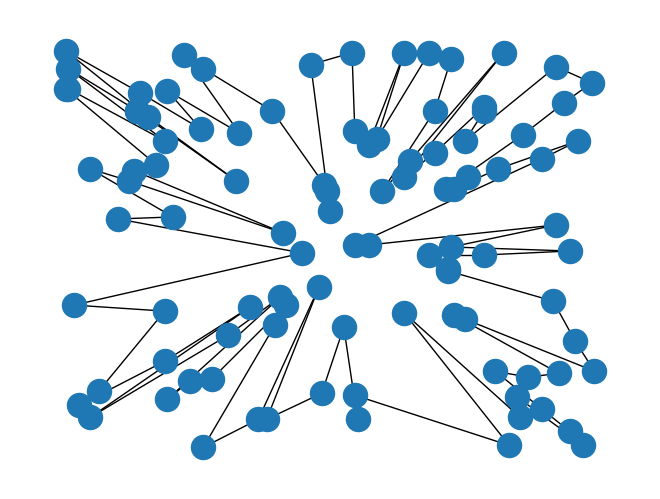

In [49]:
nx.draw(G, pos)